<h1>Numerical Methods in Julia</h1>
This Jupyter Notebook serves as supplementary material to the Julia code from the book [Numerical Methods for Scientific Computing](fff). By-and-large, the snippets agree with whats in the books, except for possibly the addition of an explicit plot statement or variable declaration. These code snippets are minimal working toy algorithms meant to better understand the mathematics that goes into them. They are tools for tinkering and learning. Play with them and have fun. And, perhaps you can repurpose a few of them. You can jump around the notebook. But, load the LinearAlgebra.jl and Plots.jl packages are available.

In [ ]:
using LinearAlgebra, Plots

<h1>Notebook Contents</h1>

 [Part 1: Numerical Linear Algebra](#label0)<br>
&emsp; [Chapter 1: A Review of Linear Algebra](#label1)<br>
&emsp; [Chapter 2: Direct Methods for Linear Systems](#label2)<br>
&emsp; [Chapter 3: Inconsistent Systems](#label3)<br>
&emsp; [Chapter 4: Computing Eigenvalues](#label4)<br>
&emsp; [Chapter 5: Iterative Methods for Linear Systems](#label5)<br>
&emsp; [Chapter 6: Fast Fourier Transform](#label6)<br>
 [Part 2: Numerical Methods for Analysis](#label7)<br>
&emsp; [Chapter 7: Preliminaries](#label8)<br>
&emsp; [Chapter 8: Solutions to Nonlinear Equations](#label9)<br>
&emsp; [Chapter 9: Interpolation](#label10)<br>
&emsp; [Chapter 10: Approximating Functions](#label11)<br>
&emsp; [Chapter 11: Differentiation and Integration](#label12)<br>
 [Part 3: Numerical Partial Differential Equations](#label13)<br>
&emsp; [Chapter 12: Ordinary Differential Equations](#label14)<br>
&emsp; [Chapter 13: Parabolic Equations](#label15)<br>
&emsp; [Chapter 16: Fourier Spectral Methods](#label16)<br>
 [Part 4: Solutions](#label17)<br>
&emsp; [Numerical Linear Algebra](#label18)<br>
&emsp; [Numerical Analysis](#label19)<br>
&emsp; [Numerical Partial Differential Equations](#label20)<br>


<a name="label0"></a>
# Part 1: Numerical Linear Algebra
<a name="label1"></a>
## Chapter 1: A Review of Linear Algebra
**The Hilbert matrix.**

In [ ]:
hilbert(n)  = [1/(i+j-1) for i=1:n, j=1:n]

In [ ]:
using Images
[Gray.(1 .- abs.(hilbert(n)\hilbert(n))) for n ∈ (10,15,20,25,50)]

<a name="label2"></a>
## Chapter 2: Direct Methods for Linear Systems
**Gaussian elimination.** The following function implements a naïve Gaussian elimination algorithm for a matrix `A` and vector `b`. We'll verify the code using a random matrix-vector pair. 

In [ ]:
function gaussian_elimination(A,b)
  n = size(A,1)
  for j in 1:n
    A[j+1:n,j] /= A[j,j]
    A[j+1:n,j+1:n] -= A[j+1:n,j:j].*A[j:j,j+1:n]
  end
  for i in 2:n
    b[i:i] -= A[i:i,1:i-1]*b[1:i-1]
  end
  for i in n:-1:1
    b[i:i] = ( b[i] .- A[i:i,i+1:n]*b[i+1:n] )/A[i,i]
  end
  return b
end

In [ ]:
A = rand(8,8); b = rand(8,1)
[A\b gaussian_elimination(A,b)]

**Simplex method.** The following three functions (`get_pivot`, `row_reduce`, and `simplex`) implement a naïve simplex method

In [ ]:
function row_reduce(tableau,p)
   (i,j) = get_pivot(tableau)
   p[filter(x->x==i, p)] .= 0; p[j] = i 
   G = tableau[i:i,:]/tableau[i,j]
   tableau -= tableau[:,j:j]*G
   tableau[i,:] = G
  return(tableau,p)
end

In [ ]:
function get_pivot(tableau)
  j = argmax(tableau[end,1:end-1])
  a, b = tableau[1:end-1,j], tableau[1:end-1,end]
  k = findall(x-> x>0 , a)
  i = k[argmin(b[k]/a[k])]
  return(i,j) 
end

In [ ]:
function simplex(A,b,c)
  (m,n) = size(A)
  tableau = [[A I b] ; [c' zeros(1,m) 0]]
  p = zeros(Int32,1,m+n)
  while (any(tableau[end,1:end-1].>0))
    (tableau,p) = row_reduce(tableau,p)
  end
  x = [0;tableau[1:end-1,end]][p[1:n].+1]
  z = -tableau[end,end]
  return(z,x)
end

In [ ]:
unit(n,i) = (z=zeros(n,1);z[i]=1;z)
using SparseArrays
function revised_simplex(A,b,c)
 (m,n) = size(A)
  N = Vector(1:n); B = Vector(n .+ (1:m))
  A = [sparse(A) sparse(I, m, m)]
  ABinv = sparse(I, m, m)
  c = [c;zeros(m,1)]
  while(true)
    j = findfirst(x->x>0,(c[N]'.-(c[B]'*ABinv)*A[:,N])[:])
    if isnothing(j); break; end
    q = ABinv*A[:,N[j]]
    k = findall(x->x>0,q)
    i = k[argmin(ABinv[k,:]*b./q[k])]
    B[i], N[j] = N[j], B[i]
    ABinv -=  ((q - unit(m,i))/q[i])*ABinv[i:i,:]
  end
  i = findall(x -> x≤n, B)
  x = zeros(n,1)
  x[B[i]] = ABinv[i,:]*b
  z = c[1:n]'*x
  return(x,z)
end

<a name="label3"></a>
## Chapter 3: Inconsistent Systems
The constrained least squares problem of solving $\mathbf{Ax} = \mathbf{b}$ with the constraint condition $\mathbf{Cx}=\mathbf{d}$:

In [ ]:
function constrained_lstsq(A,b,C,d)
  x = [A'*A C'; C zeros(size(C,1),size(C,1))]\[A'*b;d]
  x[1:size(A,2)]
end

The function `tls` solves the total least squares problem. We'll use it along with ordinary least squares to find Zipf's law coefficients for cannon of Sherlock Holmes.} %

In [ ]:
function tls(A,B)
  n = size(A,2)
  V = svd([A B]).V
  -V[1:n,n+1:end]/V[n+1:end,n+1:end]
end

In [ ]:
using DelimitedFiles
bucket = "https://nmfsc.s3.amazonaws.com/"
T = readdlm(download(bucket*"sherlock.csv"), '\t')[:,2]
n = length(T)
A = [ones(n,1) log.(1:n)]
B = log.(T)
c₁ = A\B
c₂ = tls(A,B)
print("ordinary least squares:\n"*string(c₁)*"\n")
print("total least squares:\n"*string(c₂))

**Image compression** Let's use singular value decomposition to compress an image. We'll choose a nominal rank `k = 20` for demonstration. We'll use the Frobenius norm to compute the total pixelwise error in the compressed image. Then, we'll plot out all the singular values for comparison.

In [ ]:
using Images
bucket= "https://nmfsc.s3.amazonaws.com/"
A = Gray.(load(download(bucket*"laura.png")))
U, σ, V = svd(A);

In [ ]:
k = 20
Aₖ = Gray.( U[:,1:k] * Diagonal(σ[1:k]) * V[:,1:k]' )

In [ ]:
norm(A-Aₖ) ≈ norm(σ[k+1:end])

In [ ]:
ϵ² = 1 .- cumsum(σ)/sum(σ); scatter(ϵ²,xaxis=:log)

**Non-negative matrix factorization (NMF).** A naive implementation of non-negative matrix factorization using multiplicative updates (without a stopping criterion):

In [ ]:
function nmf(X,p=6)
  W = rand(Float64, (size(X,1), p))
  H = rand(Float64, (p,size(X,2)))
  for i in 1:50
    W = W.*(X*H')./(W*(H*H') .+ (W.≈0))
    H = H.*(W'*X)./((W'*W)*H .+ (H.≈0))
  end
  (W,H)
end

In [ ]:
using Images
bucket= "https://nmfsc.s3.amazonaws.com/"
A = Gray.(load(download(bucket*"laura.png")))
W,H = nmf(Float64.(A),20)
Gray.(W*H)

<a name="label4"></a>
## Chapter 4: Computing Eigenvalues
The function `condeig` computes the eigenvalue condition number. Let's use it on a small random matrix.

In [ ]:
function condeig(A)
  Sᵣ = eigvecs(A)
  Sₗ = inv(Sᵣ')
  Sₗ ./= sqrt.(sum(abs.(Sₗ.^2), dims=1))
  1 ./ abs.(sum(Sᵣ.*Sₗ, dims=1))
end

In [ ]:
condeig(rand(4,4))

The following minimal code computes the PageRank of the very  small graph by using the power method over 9 iterations <img src="https://nmfsc.s3.amazonaws.com/internet_graph.svg" alt="internet graph" title="internet graph" />

In [ ]:
H = [0 0 0 0 1; 1 0 0 0 0; 1 0 0 0 1; 1 0 1 0 0; 0 0 1 1 0]
v = all(x->x==0,H,dims=1)
H = H ./ (sum(H,dims=1)+v) 
n = size(H,1) 
d = 0.85
x = ones(n,1)/n
for i in 1:9
  x = d*(H*x) .+ d/n*(v*x)  .+ (1-d)/n
end 
x

<a name="label5"></a>
## Chapter 5: Iterative Methods for Linear Systems
 Let's set up a sparse matrix

In [ ]:
using SparseArrays
n = 50; x = (1:n)/(n+1); Δx = 1/(n+1) 
J = sparse(I, n, n)
D = spdiagm(-1 => ones(n-1), 0 => -2ones(n), 1 => ones(n-1) )
A = (kron(kron(D,J),J)+kron(J,kron(D,J))+kron(J,kron(J,D)))/Δx^2

<a name="label6"></a>
## Chapter 6: Fast Fourier Transform
This chapter introduces several naive functions. The radix-2 FFT algorithm is written as a recursive function `fftx2` and the inverse FFT is written as `ifftx2`. The function `fasttoeplitz` computes the Toeplitz multiplication by padding out a Toeplitz matrix with zeros to make it circulant. And `bluestein` implements the Bluestein algorithm using fast Toeplitz multiplication.<a name=\"radix2fft\"></a>

In [ ]:
function fftx2(c)
  n = length(c)
  ω = exp(-2im*π/n)
  if mod(n,2) == 0 
    k = collect(0:n/2-1)
    u = fftx2(c[1:2:n-1])
    v = (ω.^k).*fftx2(c[2:2:n]) 
    return([u+v; u-v])
  else 
    k = collect(0:n-1)
    F = ω.^(k*k')
    return(F*c)
  end 
end

In [ ]:
ifftx2(y) = conj(fftx2(conj(y)))/length(y);

In [ ]:
function fasttoeplitz(c,r,x)
  n = length(x)
  Δ = nextpow(2,n) - n
  x₁ = [c; zeros(Δ); r[end:-1:2]]
  x₂ = [x; zeros(Δ+n-1)]
  ifftx2(fftx2(x₁).*fftx2(x₂))[1:n]
end

In [ ]:
using FFTW, Primes, Plots
N = 10000
smooth(n,N) = (1:N)[all.(x->x<=n,factor.(Set,1:N))]
t₁ = [(x = randn(n); (n,@elapsed(fft(x)))) for n∈primes(N)]
t₂ = [(x = randn(n); (n,@elapsed(fft(x)))) for n∈smooth(5,N)]
plot(t₁,label="prime"); plot!(t₂,label="5-smooth")
plot!(ylims=(0,t₁[end][2]*3))

In [ ]:
function bluestein(x)
  n = length(x)
  ω = exp.((1im*π/n)*(0:n-1).^2)
  ω.*fasttoeplitz(conj(ω),conj(ω),ω.*x)
end

In [ ]:
using Primes
function primitiveroot(n)
  ϕ = n - 1
  p = factor(Set,ϕ)
  for r = 2:n-1
    all([powermod(r, ϕ÷pᵢ, n) for pᵢ∈p].!=1) && return(r)
  end
end

In [ ]:
function rader_fft(x)
  n = length(x)
  r = primitiveroot(n)
  P₊ = powermod.(r, 0:n-2, n)
  P₋ = circshift(reverse(P₊),1)
  ω = exp.((2im*π/n)*P₋)
  c = x[1] .+ ifft(fft(ω).*fft(x[2:end][P₊]))
  [sum(x); c[reverse(invperm(P₋))]]    
end

**Fast Poisson solver.** The following set of functions solves the Poisson equation using a naive fast Poisson solver.

In [ ]:
using FFTW
dst(x) = FFTW.r2r(x,FFTW.RODFT00)
idst(x) = dst(x)/(2^ndims(x)*prod(size(x).+1))

In [ ]:
n = 50; x = (1:n)/(n+1); Δx = 1/(n+1) 
v = 2 .- 2cos.(x*π) 
λ = [v[i]+v[j]+v[k] for i∈1:n, j∈1:n, k∈1:n]./Δx^2
f = [(x-x^2)*(y-y^2) + (x-x^2)*(z-z^2)+(y-y^2)*(z-z^2) 
    for x∈x,y∈x,z∈x]
u = idst(dst(f)./λ);

In [ ]:
norm(u - [(x-x^2)*(y-y^2)*(z-z^2)/2 for x∈x,y∈x,z∈x])

**Image compression.** Let's consider the following code that compresses a grayscale image `A` to a factor of `p` from its original size. 

In [ ]:
using Images, FFTW
function dctcompress(A,p)
  m,n = size(A)  
  mₚ,nₚ = Int.(floor.((m,n).*sqrt(p)))
  Bₚ = dct(Float64.(A))[1:mₚ,1:nₚ]
  Aₚ = idct([Bₚ zeros(mₚ,n-nₚ); zeros(m-mₚ,n)])
  Gray.(clamp01!(Aₚ))
end

In [ ]:
using Images
bucket= "https://nmfsc.s3.amazonaws.com/"
A = Gray.(load(download(bucket*"laura.png")))
[A dctcompress(A,0.05)]

<a name="label7"></a>
# Part 2: Numerical Methods for Analysis
<a name="label8"></a>
## Chapter 7: Preliminaries
Let's start with a function that returns a double-precision floating-point representation as a string of bits.

In [ ]:
bitstring(Float64(π))

**Rumpf's catastrophic cancellation.**

In [ ]:
a = 77617; b = 33096
333.75*b^6+a^2*(11*a^2*b^2-b^6-121*b^4-2)+5.5*b^8+a/(2*b)

`NaN` can be used to lift "pen off paper" when plotting a series of connected points.

In [ ]:
plot([1,2,2,2,3],[1,2,NaN,1,2])

<a name="label9"></a>
## Chapter 8: Solutions to Nonlinear Equations
We start with simple implementation of the bisection method.

In [ ]:
function bisection(f,a,b,tolerance)
  while abs(b-a) > tolerance
    c = (a+b)/2
    sign(f(c)) == sign(f(a)) ? a = c : b = c
  end
  (a+b)/2
end

In [ ]:
bisection(x->sin(x),2,4,1e-14)

**The Mandelbrot set**. The following function takes the array `bb` for the lower-left and upper-right corners of the bounding box; `xpix` for the number of horizontal pixels; `n` for the maximum number of iterations; and `s` for the starting value $z^{(0)}$, which for the Mandelbrot set is 0. The function returns a two-dimensional array `M` that counts the number of iterations `k` to escape: $|z^{(k)}|>2$. We'll then use this function to generate an image.

In [ ]:
function mandelbrot(bb,xpix,n,s)
  ypix = round(Int,xpix*(bb[4]-bb[2])/(bb[3]-bb[1]))
  M = zeros(Int,ypix,xpix)
  z = float(s)*ones(Complex,ypix,xpix)
  c = LinRange(bb[1],bb[3],xpix)' .+
    im*LinRange(bb[4],bb[2],ypix)
  for k in 1:n
    mask = (abs.(z) .< 2)
    M[mask] = M[mask] .+ 1
    z[mask] = z[mask].^2 .+ c[mask]
  end
  return(M)
end

In [ ]:
using Images
M = mandelbrot([-0.172, 1.0228, -0.1494, 1.0443],800,200,0)
save("mandelbrot.png",1 .- M./maximum(M))
load("mandelbrot.png")

Imaging the Julia set uses almost identical code. The Mandelbrot set lives in the $c$-domain with a given value $z^{(0)}=0$, and the Julia set lives in the $z$-domain with a given value $c$. So the code for the Julia set requires only swapping the initializations for variables `z` and `c` in the code.

In [ ]:
function julia(bb,xpix,n,s)
  ypix = round(Int,xpix*(bb[4]-bb[2])/(bb[3]-bb[1]))
  M = zeros(Int,ypix,xpix)
  z = float(s)*ones(Complex,ypix,xpix)
  c = LinRange(bb[1],bb[3],xpix)' .+
    im*LinRange(bb[4],bb[2],ypix)
 ((c,z)=(z,c))
  for k in 1:n
    mask = (abs.(z) .< 2)
    M[mask] = M[mask] .+ 1
    z[mask] = z[mask].^2 .+ c[mask]
  end
  return(M)
end

In [ ]:
J = julia([-2 -1 2 1],800,100,-1+0.3im)
save("julia.png",1 .- J./maximum(J))
load("julia.png")

**Homotopy continuation**. The following snippet of code finds a root of $$x^3-3xy^2-1 =0$$
$$y^3-3x^2y = 0$$ with an initial guess $(x,y) = (1,1)$ using homotopy continuation: 

In [ ]:
using DifferentialEquations
f = z -> ((x,y)=tuple(z...);
  [x^3-3x*y^2-1; y^3-3x^2*y])
df = (z,p,_) -> ((x,y)=tuple(z...);
  -[3x^2-3y^2 -6x*y; -6x*y 3y^2-3x^2]\p)
z₀ = [1,1]
sol = solve(ODEProblem(df,z₀,(0,1),f(z₀)))
sol.u[end]

<a name="label10"></a>
## Chapter 9: Interpolation
 **Splines.** The function `spline_natural` computes the coefficients `m` of a cubic spline with natural boundary conditions through the nodes given by the arrays `x` and `y`. The function `evaluate_spline` returns a set of `n` points along the spline. The final code snippet tests these functions with several randomly selected points.<a name=\"spline_natural\"></n>

In [ ]:
function spline_natural(xᵢ,yᵢ)
  h = diff(xᵢ)
  γ = 6*diff(diff(yᵢ)./h)
  α = h[2:end-1]
  β = 2(h[1:end-1]+h[2:end])
  [0;SymTridiagonal(β,α)\γ;0]
end

In [ ]:
function evaluate_spline(xᵢ,yᵢ,m,n)
  h = diff(xᵢ)
  B = yᵢ[1:end-1] .- m[1:end-1].*h.^2/6
  A = diff(yᵢ)./h - h./6 .*diff(m)
  x = range(minimum(xᵢ),maximum(xᵢ),length=n+1)
  i = sum(xᵢ' .≤ x,dims=2)
  i[end] = length(xᵢ)-1 
  y = @. (m[i]*(xᵢ[i+1]-x)^3 + m[i+1]*(x-xᵢ[i])^3)/(6h[i]) +
     A[i]*(x-xᵢ[i]) + B[i]
  return(x,y)
end

In [ ]:
x = LinRange(0,1,8); y = rand(8)
m = spline_natural(x,y)
X,Y = evaluate_spline(x,y,m,100)
scatter(x,y); plot!(X,Y)

The Julia Dierckx.jl package provides a wrapper of the dierckx Fortran library developed by Paul Dierckx.  This package provides an easy interface to building splines. Let's create a function and select some knots.

In [ ]:
g = x-> @. max(1-abs(3-x),0)
xᵢ = 0:5; yᵢ = g(xᵢ)
x = LinRange(0,5,101);

In [ ]:
using Dierckx, Plots
spline = Spline1D(xᵢ,yᵢ)
plot(x,spline(x)); plot!(x,g(x)); scatter!(xᵢ,yᵢ)

The Interpolations.jl package, which is still under development, can be used to evaluate up through third-order B-splines, but the nodes must be equally spaced. Let's fit a spline through the knots that we generated earlier.

In [ ]:
using Interpolations
method = BSpline(Cubic(Natural(OnGrid())))
spline =  scale(interpolate(yᵢ, method), xᵢ)
plot(x,spline(x)); plot!(x,g(x)); scatter!(xᵢ,yᵢ)

In [ ]:
bernstein(n,t) = @. binomial(n,0:n)'*t^(0:n)'*(1-t)^(n:-1:0)'

In [ ]:
n = 3
t = LinRange(0,1,100)
p = rand(n+1,2)
z = bernstein(n,t)*p
plot(p[:,1],p[:,2],marker=:o,opacity=0.3); 
plot!(z[:,1],z[:,2],legend=:none)

**Bézier cirves.** The following function builds a Bernstein matrix. We'll then test the function on a set of points to create a cubic Bézier curve with a set of four randomly selected control points. 

<a name="label11"></a>
## Chapter 10: Approximating Functions
 **Legendre ploynomials** We can evaluate a Legendre polynomial of order $n$ using Bonnet's recursion formula.

In [ ]:
function legendre(x,n)
  n==0 && return(one.(x))
  n==1 && return(x)
  x.*legendre(x,n-1) .- (n-1)^2/(4(n-1)^2-1)*legendre(x,n-2)
end

In [ ]:
x = LinRange(-1,1,100)
plot()
for n in 0:4
    plot!(x,legendre(x,n)) 
end
current()

**Wavelets**. The function `scaling` returns the scaling function (father wavelet). We can use it to generate the wavelet function (mother wavelet). As an example, we will plot the Daubechies $D_4$ with $c_k = (1+\sqrt{3},3+\sqrt{3},3-\sqrt{3},1-\sqrt{3}])/4$ and $\phi(k) = (0,1+\sqrt{3},1-\sqrt{3},0)/2$.

In [ ]:
using OffsetArrays
function scaling(c,ϕₖ,n)
  m = length(c)-1; ℓ = 2^n
  ϕ = OffsetVector(zeros(3*m*ℓ),-m*ℓ) 
  k = (0:m)*ℓ
  ϕ[k] = ϕₖ
  for j = 1:n
    for i = 1:m*2^(j-1)
      x = (2i-1)*2^(n-j)            
      ϕ[x] = c ⋅ ϕ[2x .- k]
    end
  end
  ((0:m*ℓ-1)/ℓ, ϕ[0:m*ℓ-1])
end

In [ ]:
c = [1+√3,3+√3,3-√3,1-√3]/4
z = [0,1+√3,1-√3,0]/2
(x,ϕ) = scaling(c, z, 8)
plot(x,ϕ)

In [ ]:
ψ = zero(ϕ); n = length(c)-1; ℓ = length(ψ)÷2n
for k∈0:n
  ψ[(k*ℓ+1):(k+n)*ℓ] += (-1)^k*c[n-k+1]*ϕ[1:2:end]
end
plot(x,ψ)

**Nonlinear least squares approximation**. The function `gauss_newton` solves a nonlinear least squares problem where the Jacobian is approximated numerically using function `jacobian`. The solver is then used to find the parameters for a model logistic regression problem.<a name="jacobian"></a>

In [ ]:
function gauss_newton(x,y,c,f)
  r = y - f(c,x) 
  for j in 1:50
    c += jacobian(f,c,x)\r
    norm(r-(r=y-f(c,x))) < 1e-12 && return(c)
  end
  print("Gauss-Newton did not converge.")
end

In [ ]:
function jacobian(f,c,x)
  J = zeros(length(x),length(c))
  for k in (n = 1:length(c))
    J[:,k] .= imag(f(c+1e-8im*(k .== n),x))/1e-8
  end
  return(J)
end

In [ ]:
x = [randn(10);randn(10) .+ 1]
y = [zeros(10);ones(10)]
f = (c,x) -> @. 1/(exp(-c[1]*(x-c[2]))+1)
c = gauss_newton(x,y,[1;2],f)

In [ ]:
X = LinRange(-4,6,100)
scatter(x,y,opacity=0.6);
plot!(X,f(c,X),legend=:none)

<a name="label12"></a>
## Chapter 11: Differentiation and Integration
 Let's compute the coefficients to the third-order approximation to $f'(x)$ using nodes at $x-h$, $x$, $x+h$ and $x+2h$. 

In [ ]:
d = [-1,0,1,2]
n = length(d)
V = d.^(0:n-1)' .// factorial.(0:n-1)'
C = inv(V)

**Richardson extrapolation**. $D(\phi(x))$ of a finite difference operator $\phi(x)$.<a name="richardson_extrapolation"></a>

In [ ]:
function richardson(f,x,m,n=m)
  n > 0 ? 
  (4^n*richardson(f,x,m,n-1) - richardson(f,x,m-1,n-1))/(4^n-1) :
  ϕ(f,x,2^m)  
end

In [ ]:
ϕ = (f,x,n) -> (f(x+1/n) - f(x-1/n))/(2/n)

In [ ]:
richardson(x->sin(x),0,4)

**Automatic differentiation**. <a name="dualclass"></a> We can build a minimal working example of a forward accumulation automatic differentiation by defining a class and overloading the base operators.  We'll verify the code using the funtion $x + \sin x$. 

In [ ]:
struct Dual
  value
  deriv
end

In [ ]:
Dual(x) = Dual(x,1)
value(x) = x isa Dual ? x.value : x
deriv(x) = x isa Dual ? x.deriv : 0

In [ ]:
Base.:+(u, v) = Dual(value(u)+value(v), deriv(u)+deriv(v))
Base.:-(u, v) = Dual(value(u)-value(v), deriv(u)-deriv(v))
Base.:*(u, v) = Dual(value(u)*value(v), 
   value(u)*deriv(v)+value(v)*deriv(u))
Base.:sin(u)  =  Dual(sin(value(u)), cos(value(u))*deriv(u))

In [ ]:
x = Dual(0)
y = x + sin(x)

Now, let's apply the code above to compute the Jacobian of the system $$y_1 = x_1x_2 + \sin x_2$$$$y_2 = x_1x_2 - \sin x_2$$ evaluated at $(x_1,x_2) = (2,\pi)$.

In [ ]:
x₁ = Dual(2,[1 0])
x₂ = Dual(π,[0 1])
y₁ = x₁*x₂ + sin(x₂)
y₂ = x₁*x₂ - sin(x₂)
value(y₁),value(y₁),deriv(y₁),deriv(y₂)

**Romberg method**. We can use the following trapezoidal quadrature  to make a Romberg method using Richardson extrapolation. We first define the function `trapezoidal` for composite trapezoidal quadrature. By redefine `phi` to equal `trapezoidal` we can simply apply the function `D` that we used to define Richardson extrapolation. We'll verify the code by integrating $\sin x$ from $0$ to $\pi/2$.

In [ ]:
function trapezoidal(f,x,n) 
  F = f.(LinRange(x[1],x[2],n+1))
  (F[1]/2 + sum(F[2:end-1]) + F[end]/2)*(x[2]-x[1])/n
end

In [ ]:
ϕ = (f,x,n) -> trapezoidal(f,x,n)

In [ ]:
richardson(x->sin(x),[0,π/2],4)

**Composite trapezoidal method**. Let's examine the convergence rate for the composite trapezoidal rule applied to the function $f(x) = x + (x - x^2)^p$ over the interval $[0,2]$ with $p = 1,2,\dots,7$. We can do this by finding the loglog slope of the error as a function of subintervals $n$. We find that the error of the trapezoidal rule is $O(n^2)$ when $p=1$, $O(n^4)$ when $p$ is 2 or 3, $O(n^6)$ when $p$ is 4 or 5, and so on.

In [ ]:
n = [floor(Int,10^y) for y in LinRange(1, 2, 10)]
error = zeros(10,7)
f = (x,p) -> x + x.^p.*(2-x).^p
for p ∈ 1:7,
  S = trapezoidal(x->f(x,p),[0,2],10^6)
  for i ∈ 1:length(n)
    Sₙ = trapezoidal(x->f(x,p),[0,2],n[i])
    error[i,p] =  abs(Sₙ - S)/S
  end
end
slope = ([log.(n) one.(n)]\log.(error))[1,:]
info = .*(string.((1:7)'),": slope=",string.(round.(slope')))
plot(n,error, xaxis=:log, yaxis=:log, labels = info)

**Clenshaw-Curtis quadrature**. applies the trapezoidal rule to a discrete cosine transform (type-1) as a means of numerically evaluating the integral $\int_{-1}^{1} f(x) \,\mathrm{d}x.$  We'll test the integral on the function $f(x) = 8 \cos x^2$, with an integral of approximately 0.566566

In [ ]:
using FFTW, LinearAlgebra
function clenshaw_curtis(f,n)
  x = cos.(π*(0:n)'/n)
  w = zeros(n+1,1); w[1:2:n+1] = 2 ./ (1 .- (0:2:n).^2)
  1/n * dctI(f.(x)) ⋅ w
end

In [ ]:
function dctI(f) 
  g = FFTW.r2r!([f...],FFTW.REDFT00)
  [g[1]/2; g[2:end-1]; g[end]/2]  
end

In [ ]:
clenshaw_curtis(x -> cos(8x^2),20)

A mathematical comment: we could have also  defined a type-1 DCT explicitly in terms of its underlying FFTs if we wanted to crack the black box open just a wee bit more.

In [ ]:
function dctI(f)
  n = length(f)
  g = real(fft(f[[1:n; n-1:-1:2]]))
  [g[1]/2; g[2:n-1]; g[n]/2]  
end

**Gauss–Legendre quadrature.** We first compute the Legendre weights and nodes and then apply Gauss–Legendre quadrature to compute $$\int_{-1}^{1} \cos x \cdot \mathrm{e}^{-x^2} \,\mathrm{d}x$$ using a nominal number of nodes $n=8$. 

In [ ]:
function gauss_legendre(n)
  a = zeros(n)  
  b = (1:n-1).^2 ./ (4*(1:n-1).^2 .- 1)
  𝟙² = 2
  λ, v = eigen(SymTridiagonal(a, sqrt.(b))) 
  (λ, 𝟙²*v[1,:].^2)
end

In [ ]:
n = 8
f(x) = cos(x)*exp(-x^2);
nodes, weights = gauss_legendre(n)
f.(nodes) ⋅ weights

Alternatively, the Julia library FastGaussQuadrature.jl gives a fast, accurate method of computing the nodes and weights

In [ ]:
using FastGaussQuadrature
nodes, weights = gausslegendre(n)
f.(nodes) ⋅ weights

<a name="label13"></a>
# Part 3: Numerical Partial Differential Equations
<a name="label14"></a>
## Chapter 12: Ordinary Differential Equations
 Let's plot the boundary of the region of absolute stability for BDF2: $$z = \frac{\frac{3}{2} r^2 - 2 r + \frac{1}{2}}{r^2}$$

In [ ]:
r = exp.(2im*π*(0:.01:1))
plot(@. (1.5r^2 - 2r + 0.5)/r^2)

**Multistep coefficients**. The function `multistepcoeffs` determines the multistep coefficients for stencil given by `m` and `n`. The function `plotstability` uses these coefficients to plot boundary of the region of absolute stability. We'll test it on the Adams–Moulton method with input `m = [1]` and `n = [0 1 2]`.<a name="multistepcoeffs"></a>

In [ ]:
function multistepcoeffs(m,n)
  s = length(m) + length(n)
  A = (m.+1).^(0:s-1)
  B = (0:s-1).*(n.+1).^(0:s-1).//(n.+1)
  c = -[A B]\ones(Int64,s)
  [1;c[1:length(m)]], c[(length(m)+1):end] 
end

In [ ]:
function plotstability(a,b)
  λk(r) = (a ⋅ r.^(0:length(a)-1)) ./ (b ⋅ r.^(0:length(b)-1))
  r = exp.(im*LinRange(0,2π,200))
  plot(λk.(r),label="",aspect_ratio=:equal)
end

In [ ]:
a,b = multistepcoeffs([1],[0 1 2])
plotstability(a,b)

**Recipe for solving an ODE**. The general recipe for solving an ODE is to
1. Load the module
1. Set up the parameters
1. Define the problem
1. Choose the method
1. Solve the problem
1. Present the solution

Let's apply this recipe to solve the pendulum problem $u'' = \sin u$ with initial conditions $u(0) = \pi/9$ and $u'(0) = 0$ over $t\in[0,8\pi]$.

In [ ]:
using DifferentialEquations, Plots
pendulum(u,p,t) = [u[2]; -sin(u[1])]
u₀ = [8π/9,0]; tspan = [0,8π]
problem = ODEProblem(pendulum, u₀, tspan)
method = Trapezoid()
solution = solve(problem,method)
plot(solution, xaxis="t", label=["θ" "ω"])

<a name="label15"></a>
## Chapter 13: Parabolic Equations
**Heat equation using the backward Euler method**. Let's solve the heat equation using the backward Euler method with initial conditions given by a rectangular function and absorbing boundary conditions.

In [ ]:
Δx = .01; Δt = .01; L = 2; λ = Δt/Δx^2; uₗ = 0; uᵣ = 0;
x = collect(-L:Δx:L); n = length(x) 
u = (abs.(x).<1)
u[1] += 2λ*uₗ; u[n] += 2λ*uᵣ 
D = Tridiagonal(ones(n-1), -2ones(n), ones(n-1))
D[1,2] = 0; D[n,n-1] = 0
A = I - λ*D 
for i in 1:20
  u = A\u
end
plot(x,u)

**Heat equation using the Crank–Nicolson method**. Let's solve the heat equation again using the Crank–Nicolson method with initial conditions given by a rectangular function. This time we'll use reflecting boundary conditions. Notice how the high-frequency information does not decay as it did when using the backward Euler method.

In [ ]:
Δx = .01; Δt = .01; L = 2; λ = Δt/Δx^2
x = collect(-L:Δx:L); n = length(x) 
u = (abs.(x).<1)
D = Tridiagonal(ones(n-1), -2ones(n), ones(n-1))
D[1,2] = 2; D[n,n-1] = 2
A = 2I + λ*D 
B = 2I - λ*D 
anim = @animate for i in 1:20
  plot(x,u, legend=:none, ylims=(0,1))
  u = B\(A*u)
end
gif(anim, "heat.gif", fps = 5)

**Porous medium equation**. We'll now solve the porous medium equation $u_t = (u^2u_x)_x$ using an adaptive-step BDF routine.

In [ ]:
using Sundials
n = 400; L = 2; x = LinRange(-L,L,n); Δx = x[2]-x[1]
m = (u -> u.^2)
Du(u,Δx,t) = [0;diff(m((u[1:end-1]+u[2:end])/2).*diff(u))/Δx^2;0]
u₀ = (abs.(x).<1)
problem = ODEProblem(Du,u₀,(0,2),Δx)
method = CVODE_BDF(linear_solver=:Band, jac_lower=1, jac_upper=1)
solution = solve(problem, method);

In [ ]:
anim = @animate for t in LinRange(0,2,200)
  plot(x,solution(t),legend=:none,fill=(0,0.4,:red),ylims=(0,1))
end
gif(anim, "porous.gif", fps = 15)

In [ ]:
using Interact
@manipulate for t∈slider(0:0.01:2; value=0, label="time")
  plot(x,sol(t),  fill = (0, 0.4, :red))
  plot!(ylims=(0,1),legend=:none)
end

<a name="label16"></a>
## Chapter 16: Fourier Spectral Methods
**Incompressible Navier–Stokes equation**. Let's solve the heat equation using the backward Euler method with initial conditions given by a rectangular function and absorbing boundary conditions.

In [ ]:
Δᵒ(Q,step=1) = Q - circshift(Q,(step,0))
flux(Q,c) = c.*Δᵒ(Q) - 0.5c.*(1 .- c).*(Δᵒ(Q,1)+Δᵒ(Q,-1))
Hₒ(u,v,iξ₁,iξ₂) = -iξ₁.*fft(ifft(u).^2) - iξ₂.*fft(ifft(u).*ifft(v))

In [ ]:
using FFTW, Plots
ℓ = 2; n = 128; ϵ = 0.001; Δt = 0.001; Δx = ℓ/n
x = LinRange(Δx,L,n)'; y = x'
Q = (@. 0.5(1+tanh(10(1-abs(ℓ/2 - y)/(ℓ/4))))).*ones(1,n)
uⁿ = Q .* (1 .+ 0.5sin.(ℓ*π*x))
vⁿ = zeros(n,n) 
(uⁿ,vⁿ) = (fft(uⁿ),fft(vⁿ)) 
(uᵒ,vᵒ) = (uⁿ,vⁿ)
iξ₁ = im*fftfreq(n,n)'*(2π/ℓ)
iξ₂ = transpose(iξ₁)
ξ² = iξ₁.^2 .+ iξ₂.^2
(H₁ⁿ, H₂ⁿ) = (Hₒ(uⁿ,vⁿ,iξ₁,iξ₂),  Hₒ(vⁿ,uⁿ,iξ₂,iξ₁))
M₊ = (1/Δt .+ (ϵ/2)*ξ²)
M₋ = (1/Δt .- (ϵ/2)*ξ²);

In [ ]:
for i = 1:1200
  Q -= flux(Q,(Δt/Δx).*real(ifft(vⁿ))) +
       flux(Q',(Δt/Δx).*real(ifft(uⁿ))')'
  (H₁ⁿ⁻¹, H₂ⁿ⁻¹) = (H₁ⁿ, H₂ⁿ)  
  (H₁ⁿ, H₂ⁿ) = (Hₒ(uⁿ,vⁿ,iξ₁,iξ₂),  Hₒ(vⁿ,uⁿ,iξ₂,iξ₁))
  uᵒ = uⁿ - uᵒ + (1.5H₁ⁿ - 0.5H₁ⁿ⁻¹ + M₊.*uⁿ)./M₋
  vᵒ = vⁿ - vᵒ + (1.5H₂ⁿ - 0.5H₂ⁿ⁻¹ + M₊.*vⁿ)./M₋
  ϕ = (iξ₁.*uᵒ + iξ₂.*vᵒ)./(ξ² .+ (ξ².≈ 0)) 
  (uⁿ, vⁿ) = (uᵒ - iξ₁.*ϕ, vᵒ - iξ₂.*ϕ)
end
contour(x',y, Q,fill=true,levels=1,legend=:none)

<a name="label17"></a>
# Part 4: Solutions
<a name="label18"></a>
## Numerical Linear Algebra
**1.4. Invertibility of random (0,1) matrices.** The number of invertible $n\times n$ (0,1) matrices is known for $n$ up to 8. . (See the [On-Line Encyclopedia of Integer Sequences](http://oeis.org/A055165).) We'll approximate the ratio of invertible matrices by checking the determinants of randomly drawn ones. Let's also plot the known ration for $n=1,2,\dots,8$.

In [ ]:
using Random, LinearAlgebra, Plots
N = 10000;
n = [sum([!(det(bitrand((d,d)))≈0) 
 for i in 1:N]) for d in 1:20]
plot(n/N,marker=:o)
p = [1,6,174,22560,12514320,28836612000,270345669985440,10160459763342013440]
r = @. 2^(log2(p)-(1:8)^2)
plot!(r,marker=:square,opacity=0.5)

**2.4. Naive algorithm for the determinant**

In [ ]:
function detx(A)
  L,U,P = lu(A)
  s = 1
  for i in 1:length(P)
    m = findfirst(x->x==i,P)
    if i!=m 
       s *= -1; P[[m,i]]=P[[i,m]]
    end
  end
  s * prod(diag(U))
end

In [ ]:
A = rand(20,20)
detx(A) ≈ det(A)

**2.5. Reverse Cuthill–McKee algorithm.** The following function implements a naive reverse Cuthill–McKee algorithm  for symmetric matrices. We'll verify the algorithm by applying it to a sparse, random (0,1) matrix.

In [ ]:
function rcuthillmckee(A)
  r = sortperm(vec(sum(A.!=0,dims=2)))
  p = Int64[]
  while ~isempty(r)
    q = [popfirst!(r)]
    while ~isempty(q)
      q₁ = popfirst!(q)
      append!(p,q₁)  
      k = findall(!iszero, A[q₁,r])
      append!(q,splice!(r,k))
    end
  end
  reverse(p)
end

In [ ]:
using SparseArrays, LinearAlgebra, Plots
A = Symmetric(sprand(1000,1000,0.003))
p = rcuthillmckee(A)
plot(spy(A), spy(A[p,p]),colorbar = false)

**3.4. NIST Filippelli problem.** The Filippelli dataset was contrived by NIST to benchmark linear regression software. The Filippelli problem consists of fitting an 10th degree polynomial to the data set⁠—a rather ill-conditioned problem. We first need to download the data. Then we'll define three methods for solving the Vandermonde problem: normal equations, QR decomposition, and pseudo-inverse.

In [ ]:
vandermonde(t,n) = vec(t).^(0:n-1)'
build_poly(c,X) = vandermonde(X,length(c))*c

In [ ]:
function solve_filip(x,y,n)
  V = vandermonde(x, n)
  c = Array{Float64}(undef, 3, n)
  c[1,:] = (V'*V)\(V'*y)
  Q,R = qr(V)
  c[2,:] = R\(Matrix(Q)'*y)
  c[3,:] = pinv(V,1e-9)*y
  r = [norm(V*c[i,:]-y) for i in 1:3]
  return(c,r)
end

Now, let's solve the problem and plot the results. Let's also list the coefficients from each method alongside the official NIST coefficients. What do you notice about the coefficients? What method performs the best?

In [ ]:
using DelimitedFiles, LinearAlgebra, Plots
bucket = "https://nmfsc.s3.amazonaws.com/"
data = readdlm(download(bucket*"filip.csv"),',',Float64)
coef = readdlm(download(bucket*"filip-coeffs.csv"),',')
(x,y) = (data[:,2],data[:,1])
β,r = solve_filip(x, y, 11)
X = LinRange(minimum(x),maximum(x),200)
Y = [build_poly(β[i,:],X) for i in 1:3]
plot(X,Y); scatter!(x,y,opacity=0.5)
[coef β']

What makes the Filippelli problem a difficult problem is that the condition number of the system is huge. We can reduce the condition number by first standardizing the data before using it⁠—i.e., subtracting the mean and dividing by the standard deviation. Look at the difference in condition numbers of the Vandermonde matrix before and after standardizing the data.

In [ ]:
using Statistics
zscore(X,x=X) = (X .- mean(x))/std(x)
c,r = solve_filip(zscore(x), zscore(y), 11)
Y = [build_poly(c[i,:],zscore(X,x))*std(y).+mean(y) for i in 1:3]
plot(X,Y); scatter!(x,y,opacity=0.5)

**3.5. Modeling daily temperatures** We'll use $u(t) = c_1 \sin(2\pi t) + c_2 \cos(2\pi t) + c_3$ to model the daily temperatures using data recorded in Washington, DC. between 1967 and 1971.

In [ ]:
using CSV, DataFrames, Dates
bucket = "https://nmfsc.s3.amazonaws.com/"
data = download(bucket*"dailytemps.csv")
df = DataFrame(CSV.File(data))
t = Dates.value.(df[:,:date] .- df[1,:date])/365
u = df[:,:temperature]
model(t) = [sin.(2π*t) cos.(2π*t) one.(t)]
c = model(t)\u
scatter(df[:,:date],u,alpha=0.3)
plot!(df[:,:date],model(t)*c)

**3.6. Image recognition** We'll practice  identifying handwritten digits using the EMNIST database.  The [NIST website](https://www.nist.gov/itl/products-and-services/emnist-dataset) provides a version formatted as a Matlab MAT-file. The full container from the NIST website is quite large (around 700MB) and we only need a smaller 20MB set, so I've put a copy of the just the emnist-nist file on GitHub at this [link](https://github.com/kylenovak29/data/raw/master/emnist-mnist.mat).

In [ ]:
using MAT, Arpack, Images
bucket = "https://github.com/kylenovak29/data/raw/master/"
data = matread(download(bucket*"emnist-mnist.mat"))
train_images = data["dataset"]["train"]["images"]
train_labels = data["dataset"]["train"]["labels"][:]
V = zeros(12,784,10)
for i in 0:9
  D = train_images[train_labels.==i,:]
  S = svds(D,nsv=12)[1]
  V[:,:,i+1] = S.Vt  
end
pix = reshape(V[1:10,:,10]',28,28*10)
pix = (pix.-minimum(pix))./(maximum(pix)-minimum(pix))
Gray.(pix)

In [ ]:
test_images = data["dataset"]["test"]["images"]'
test_labels = data["dataset"]["test"]["labels"][:]
r = zeros(10,10000)
for i in 1:10
  q = V[:,:,i]'*(V[:,:,i]*test_images) .- test_images
  r[i,:]  = sum(q.^2,dims=1)
end
guess = first.(Tuple.(argmin(r,dims=1))) .- 1
confusion = zeros(Int,10,10)
for i in 0:9 
  x = guess[test_labels .== i] 
  confusion[i+1,:] = [sum(x .== j) for j in 0:9]
end
confusion

**4.2. Girko's circular law** Let's plot out the eigenvalues of a few thousand normal random matrices of size $n$ to get a probability distribution in the complex plane.  What do you notice?

In [ ]:
n = 8
E = collect(Iterators.flatten([eigvals(randn(n,n)) for i∈1:2000]))
scatter(E,mc=:black,ma=0.05,legend=nothing,aspect_ratio=:equal)

**4.4. Rayleigh quotient iteration** Let's define a function that finds an eigenvalue $\lambda$ and eigenvector $\mathbf{x}$ of a matrix. We'll pick a random initial guess for $\mathbf{x}$ unless one is given. We'll then verify the algorithm on a symmetric matrix. Rayleigh quotient iteration works on general classes of matrices, but often has difficulty converging when matrices get large or far from symmetric⁠—i.e., when eigenvectors get closer together.

In [ ]:
using LinearAlgebra
function rayleigh(A)
  x = randn(size(A,1),1)
  while true
    x = x/norm(x) 
    rho = (x'*A*x)[1]
    M = A - rho*I
    abs(cond(M, 1)) < 1e12 ? x = M\x : return(rho,x)
  end
end
A = [2 3 6 4; 3 0 3 1; 6 3 8 8; 4 1 8 2]
rayleigh(A)

**4.5. Implicit QR method** We'll define a function that computes all the eigenvalues of a matrix using the implicit QR method. We'll then verify the algorithm on a matrix with known eigenvalues.

In [ ]:
function implicitqr(A)
  n = size(A,1)
  tolerance = 1E-12
  H = Matrix(hessenberg(A).H)
  while true
    if abs(H[n,n-1])<tolerance
      if (n-=1)<2;  return(diag(H)); end
    end
    Q = givens([H[1,1]-H[n,n];H[2,1]],1,2)[1]
    H[1:2,1:n] = Q*H[1:2,1:n]
    H[1:n,1:2] = H[1:n,1:2]*Q'
    for i = 2:n-1
      Q = givens([H[i,i-1];H[i+1,i-1]],1,2)[1]
      H[i:i+1,1:n] = Q*H[i:i+1,1:n]
      H[1:n,i:i+1] = H[1:n,i:i+1]*Q'
    end
  end
end
n = 20; S = randn(n,n)
D = Diagonal(1:n); A = S*D*inv(S)
implicitqr(A)

**4.6. Randomized SVD** We define a method that implements randomized SVD. The idea is to start with a set of $k$ random vectors and perform a few steps of the simple QR method to generate a $k$-dimensional subspace that is closer to the space of dominant singular values. Then, we perform SVD on that subspace. We may not get the exact singular values, but it we just need a good guess and the matrix is huge, this method can be significantly faster than SVD or sparse SVD.

In [ ]:
function randomizedsvd(A,k)
  Z = rand(size(A,2),k);
  Q = Matrix(qr(A*Z).Q)
  for i in  1:3
    Q = Matrix(qr(A'*Q).Q)
    Q = Matrix(qr(A*Q).Q)
  end
  W = svd(Q'*A)
  return((Q*W.U,W.S,W.V))  
end

In [ ]:
using FileIO, Images
bucket = "https://nmfsc.s3.amazonaws.com/"
img = load(download(bucket*"red-fox.jpg"))
A = Float64.(Gray.(img))
U,S,V = randomizedsvd(A,10)
Gray.([A U*Diagonal(S)*V])

In [ ]:
using Arpack
@time randomizedsvd(A,10)
@time svds(A, nsv=10)
@time svd(A);

**6.1. Radix-3 FFT** The radix-3 FFT is similar to the [radix-2 FFT](#radix2FFT). We'll verify that the code is correct by comparing it with a built-in FFT

In [ ]:
function fftx3(c)
  n = length(c)
  ω = exp(-2im*π/n)
  if mod(n,3) == 0 
    k = collect(0:n/3-1)
    u = [transpose(fftx3(c[1:3:n-2]));
         transpose((ω.^k).*fftx3(c[2:3:n-1]));
         transpose((ω.^2k).*fftx3(c[3:3:n]))]  
    F = exp(-2im*π/3).^([0;1;2]*[0;1;2]')
    return(reshape(transpose(F*u),:,1))
  else 
    F =  ω.^(collect(0:n-1)*collect(0:n-1)')
    return(F*c)
  end 
end

In [ ]:
using FFTW
v = rand(24,1)
[fft(v) fftx3(v)]

**6.2. Fast multiplication** The following function uses FFTs to multiply two large integers (inputted as strings). We'll verify that the algorithm works by multplying the [RSA-129 factors](https://en.wikipedia.org/wiki/RSA_numbers#RSA-129). 

In [ ]:
using FFTW
function multiply(p_,q_)
  p = [parse.(Int,split(reverse(p_),""));zeros(length(q_),1)]
  q = [parse.(Int,split(reverse(q_),""));zeros(length(p_),1)]
  pq = Int.(round.(real.(ifft(fft(p).*fft(q)))))
  carry = pq .÷ 10
  while any(carry.>0)
    pq -= carry*10 - [0;carry[1:end-1]]
    carry = pq .÷ 10
  end
  n = findlast(x->x>0, pq)
  return(reverse(join(pq[1:n[1]])))
end

In [ ]:
p = "32769132993266709549961988190834461413177642967992942539798288533"
q = "3490529510847650949147849619903898133417764638493387843990820577"
multiply(p,q), parse(BigInt, p)*parse(BigInt, q)

In [ ]:
using Random
p = randstring('0':'9', 100000)
q = randstring('0':'9', 100000)
@time multiply(p,q)
@time parse(BigInt, p)*parse(BigInt, q);

**6.3. Fast discrete cosine transform**

In [ ]:
fft1(f) = hcat([fft(f[:,i]) for i in 1:size(f,2)]...)
ifft1(f) = hcat([ifft(f[:,i]) for i in 1:size(f,2)]...)

In [ ]:
function dctII(f)
  n = size(f,1)
  ω = exp.(-0.5im*π*(0:n-1)/n)
  return(real(ω.*fft1(f[[1:2:n; n-mod(n,2):-2:2],:])))
end

In [ ]:
function idctII(f)
  n = size(f,1)
  ω = exp.(-0.5im*π*(0:n-1)/n)
  f[1,:] = f[1,:]/2
  f[[1:2:n; n-mod(n,2):-2:2],:] = 2*real(ifft1(f./ω))
  return(f)
end

In [ ]:
dct2(f) = dctII(dctII(f')')
idct2(f) = idctII(idctII(f')')

In [ ]:
using FileIO, FFTW, Images
bucket = "https://nmfsc.s3.amazonaws.com/"
img = load(download(bucket*"red-fox.jpg"))
f = dct2(Float64.(Gray.(img)))
f[51:end,:] .= 0; f[:,51:end] .= 0
f = idct2(f)
[Gray.(img) Gray.(f)]

<a name="label19"></a>
## Numerical Analysis
**8.9. Solving a nonlinear system.** We'll solve $$(x^2+y^2)^2 - 2 (x^2 - y^2) =0$$ $$(x^2+y^2 -1)^3-x^2y^3 = 0$$ using homotopy continuation and Newton's method.

In [ ]:
using DifferentialEquations
function homotopy(f,df,x)
  dxdt(x,p,t) = -df(x)\p
  sol = solve(ODEProblem(dxdt,x,(0.0,1.0),f(x)))
  sol.u[end]
end

In [ ]:
function newton(f,df,x)
  for i in 1:100
    Δx = -df(x)\f(x)
    norm(Δx) > 1e-8 ? x += Δx : return(x)
  end
end

In [ ]:
f = z -> ((x,y)=tuple(z...);
  [(x^2+y^2)^2-2(x^2-y^2); (x^2+y^2-1)^3-x^2*y^3])
df = z -> ((x,y)=tuple(z...);
  [4x*(x^2+y^2-1)  4y*(x^2+y^2+1);
   6x*(x^2+y^2-1)^2-2x*y^3  6y*(x^2+y^2-1)^2-3x^2*y^2])

In [ ]:
display(homotopy(f,df,[1,1]))
display(newton(f,df,[1,1]))

**9.2. Periodic parametric splines.** We modify the code [`spline_natural`](#spline_natural) (above) to  make a generate a spine with periodic boundary conditions. The function `evaluate_spline` is duplicated from the code above.

In [ ]:
function spline_periodic(x,y)
  h = diff(x) 
  d = 6*diff(diff([y[end-1];y])./[h[end];h])
  α = h[1:end-1]
  β = 2*(h+circshift(h,1))
  C = Matrix(SymTridiagonal(β,α))
  C[1,end]=h[end]; C[end,1]=h[end] 
  m = C\d
  return([m;m[1]])
end

In [ ]:
function evaluate_spline(xᵢ,yᵢ,m,n)
  h = diff(xᵢ)
  B = yᵢ[1:end-1] .- m[1:end-1].*h.^2/6
  A = diff(yᵢ)./h - h./6 .*diff(m)
  x = range(minimum(xᵢ),maximum(xᵢ),length=n+1)
  i = sum(xᵢ' .≤ x,dims=2)
  i[end] = length(xᵢ)-1 
  y = @. (m[i]*(xᵢ[i+1]-x)^3 + m[i+1]*(x-xᵢ[i])^3)/(6h[i]) +
     A[i]*(x-xᵢ[i]) + B[i]
  return(x,y)
end

In [ ]:
n = 5; nx = 30
x = rand(n); y = rand(n)
x = [x;x[1]]; y = [y;y[1]]
t = [0;cumsum(sqrt.(diff(x).^2 + diff(y).^2))]
X = evaluate_spline(t,x,spline_periodic(t,x),nx*n)
Y = evaluate_spline(t,y,spline_periodic(t,y),nx*n)
scatter(x,y); plot!(X[2],Y[2],legend=false)

**9.3. Radial basis functions.** Let's examine how a polynomial $y(x) = \sum_{i=0}^n c_i x^i$ compares with Gaussian and cubic radial basis functions $y(x) = \sum_{i=0}^n c_i \phi(x-x_i)$ taking $\phi(x)= \exp(-20x^2)$ and $\phi(x) = |x|^3$ an interpolant of the Heaviside function.

In [ ]:
using LinearAlgebra, Plots
n = 20; N = 200
x = collect(LinRange(-1,1,n))
y = float(x .> 0);

In [ ]:
ϕ₁(x,a) = abs.(x.-a).^3
ϕ₂(x,a) = exp.(-20(x.-a).^2)
ϕ₃(x,a) = x.^a

In [ ]:
X = collect(LinRange(-1,1,N))
interp(ϕ,a)  = ϕ(X,a')*(ϕ(x,a')\y)
Y₁ = interp(ϕ₁,x)
Y₂ = interp(ϕ₂,x)
Y₃ = interp(ϕ₃,(0:n-1))
plot(x,y,seriestype = :scatter, marker = :dot, legend = :none)
plot!(X,[Y₁,Y₂,Y₃])
ylims!((-0.5,1.5))

**9.4. Collocation.** We'll use collocation to solve Bessel's equation.  We first define a function to solve general linear boundary value problems. And, then we define a function to interpolate between collocation points.

In [ ]:
function collocation_solve(L,f,bc,x)
  h = x[2]-x[1]
  S = L(x)*([1 -1/2 1/6; -2 0 2/3; 1 1/2 1/6]./[h^2 h 1])'
  d = [bc[1]; f(x); bc[2]]
  A = Matrix(Tridiagonal([S[:,1];0], [0;S[:,2];0], [0;S[:,3]]))
  A[1,1:3], A[end,end-2:end] = [1 4 1]/6, [1 4 1]/6 
  return(A\d)
end

In [ ]:
function collocation_build(c,x,N)
  X = LinRange(x[1],x[end],N)
  h = x[2] - x[1]
  i = Int32.(X .÷ h .+ 1); i[N] = i[N-1]
  C = [c[i] c[i.+1] c[i.+2] c[i.+3]]'
  B = (x->[(1-x).^3;4-3*(2-x).*x.^2;4-3*(1+x).*(1-x).^2;x.^3]/6)
  Y = sum(C.*hcat(B.((X.-x[i])/h)...),dims=1)
  return(Array(X),reshape(Y,(:,1)))
end

Now, we can solve the Bessel equation $xu''+u'+xu =0$ with boundary conditions $u(0)=1$ and $u(b)=0$.

In [ ]:
using Roots, SpecialFunctions
n = 20; N = 141
L = (x -> [x one.(x) x])
f = (x -> zero.(x) )
b = fzero(besselj0, 11)
x = range(0,b,length=n)
c = collocation_solve(L,f,[1,0],x)
X,Y = collocation_build(c,x,70)
plot(X,[Y besselj0.(X)])

Finally, we'll examine the error and convergence rate.

In [ ]:
N = 10*2 .^(1:7); ϵ = []
for n in N
  x = LinRange(0,b,n) 
  c = collocation_solve(L,f,[1,0],x)
  X,Y = collocation_build(c,x,n)
  append!(ϵ, norm(Y-besselj0.(X)) / n)
end
slope = ([log.(N) one.(N)]\log.(ϵ))[1]
s = "slope = "*string.(round.(slope,digits=2))
plot(N, ϵ, xaxis=:log, yaxis=:log, marker=:o, label=s)

**10.3. Fractional derivatives.** We'll plot the fractional derivatives for a function.

In [ ]:
using FFTW
n =256; ℓ = 2
x = (0:n-1)/n*ℓ .- ℓ/2
ξ = [0:(n/2-1); (-n/2):-1]*(2π/ℓ)
f₁ = exp.(-16*x.^2)
f₂ = sin.(π*x)
f₃ = x.*(1 .- abs.(x))
deriv(f,p) = real(ifft((im*ξ).^p.*fft(f)))

In [ ]:
using Interact
func = Dict("Gaussian"=>f₁,"sine"=>f₂,"spline"=>f₃)
@manipulate for f in togglebuttons(func; label="function"), 
  p in slider(0:0.01:2; value=0, label="derivative")
  plot(x,deriv(f,p),legend=:none)
end

**10.4. Levenberg–Marquardt method.** We find parameters for a nonlinear function that best fits our data. We'll first define a function `gauss_newton` and duplicate the function [`jacobian`](#jacobian) from above. If the Gauss–Newton method converges, then we can plot the results.

In [ ]:
function gauss_newton(x,y,c,f)
 r = y - f(c,x) 
 for j = 1:100
   G = jacobian(f,c,x)
   M = G'*G
   c += (M+Diagonal(M))\(G'*r)
   norm(r-(r=y-f(c,x))) < 1e-12 && return(c)
  end
  print("'Gauss-Newton did not converge.")
end

In [ ]:
function jacobian(f,c,x)
  J = zeros(length(x),length(c))
  for k in (n = 1:length(c))
    J[:,k] .= imag(f(c+1e-8im*(k .== n),x))/1e-8
  end
  return(J)
end

In [ ]:
f = (c,x) -> @. c[1]*exp(-c[2]*(x-c[3])^2) +
         c[4]*exp(-c[5]*(x-c[6])^2)
x = 8*rand(100)
y = f([1 3 3 2 3 6],x) + 0.1*randn(100)
c₀ = [2 0.3 2 1 0.3 7]'
c = gauss_newton(x,y,c₀,f)

In [ ]:
X = LinRange(0,8,200)
scatter(x,y,opacity=0.5)
plot!(X,f(c,X))

**11.1. Finite difference approximation.**  Let's find coefficients to the third-order approximation of $f'(x)$ for nodes at $x$, $x+h$, $x+2h$ and $x+3h$. The second row of the solution will tell us the coefficients (first four columns) and the coefficient of truncation (last column).

In [ ]:
d = [0,1,2,3]; n = length(d)
C = inv( d.^(0:n-1)' .// factorial.(0:n-1)' )
[C C*d.^n/factorial(n)]

**11.2. Richardson extrapolation.** The following code is an iterative version of the recursive [`richardson`](#richardson_extrapolation) function above:

In [ ]:
function richardson(f,x,m)
  D = []
  for i in 1:m
    append!(D, ϕ(f,x,2^i))
    for j in i-1:-1:1 
      D[j] = (4^(i-j)*D[j+1] - D[j])/(4^(i-j) - 1)
    end
  end
  D[1]
end

In [ ]:
ϕ = (f,x,n) -> (f(x+1/n) - f(x-1/n))/(2/n)
richardson(x->sin(x),0,4)

**11.3. Automatic differentiation.** Let's extend the [`Dual class`](#dualclass) above by adding methods for division, cosine, and square root to the class definition. We'll also add a few more help functions. I've copied the cells from earlier to the one below.

In [ ]:
struct Dual
  value
  deriv
end

Dual(x) = Dual(x,1)
value(x) = x isa Dual ? x.value : x
deriv(x) = x isa Dual ? x.deriv : 0

Base.:+(u, v) = Dual(value(u)+value(v), deriv(u)+deriv(v))
Base.:-(u, v) = Dual(value(u)-value(v), deriv(u)-deriv(v))
Base.:*(u, v) = Dual(value(u)*value(v), 
   value(u)*deriv(v)+value(v)*deriv(u))
Base.:sin(u)  =  Dual(sin(value(u)), cos(value(u))*deriv(u))

In [ ]:
Base.:sqrt(u) = Dual(sqrt(value(u)), deriv(u) / 2sqrt(value(u)))
Base.:/(u, v) = Dual(value(u)/value(v), 
  (value(u)*deriv(v)-value(v)*deriv(u))/(value(v)*value(v)))
Base.:cos(u)  = Dual(cos(value(u)), -sin(value(u))*deriv(u))

In [ ]:
function get_zero(f,x)
  ϵ = 1e-12; δ = 1
  while abs(δ)>ϵ
    fx = f(Dual(x))
    δ = value(fx)/deriv(fx)
    x -= δ
  end
  return(x)
end

Now, we'll can define Newton's method using this new Dual class and use it to find the zero of $4\sin x + \sqrt{x}$.

In [ ]:
get_zero(x->4sin(x)+sqrt(x),4)

We can find a minimum or maximum of $4\sin x + \sqrt{x}$ by modifying Newton's method.

In [ ]:
function get_extremum(f,x)
  ϵ = 1e-12; δ = 1
  while abs(δ)>ϵ
    fx = f(Dual(Dual(x)))
    δ = deriv(value(fx))/deriv(deriv(fx))
    x -= δ
  end
  return(x)
end

In [ ]:
get_extremum(x->4sin(x)+sqrt(x),4)

**11.4. Gauss–Legendre quadrature .** The following  function computes the nodes and weights for  Gauss–Legendre quadrature by using Newton's method to find the roots of $\mathrm{P_n}(x)$. We'll verify the function on a toy problem.

In [ ]:
function gauss_legendre(n)
  x = -cos.((4*(1:n).-1)*π/(4n+2))
  Δ = one.(x)
  dPₙ = 0
  while(maximum(abs.(Δ))>1e-16)
    Pₙ, Pₙ₋₁ = x, one.(x)
    for k∈2:n
      Pₙ, Pₙ₋₁ = ((2k - 1)*x.*Pₙ-(k-1)*Pₙ₋₁)/k, Pₙ 
    end
    dPₙ = @. n*(x*Pₙ - Pₙ₋₁)/(x^2-1)
    Δ =  Pₙ ./ dPₙ 
    x -= Δ
  end
  return(x, @. 2/((1-x^2)*dPₙ^2))
end

In [ ]:
f = (x-> 2sqrt(1-x^2))
x,w = gauss_legendre(10)
w ⋅ f.(x)

**11.6. Monte Carlo integration .** The following  function the volume of an $d$-dimensional sphere using $n$ samples and $m$ trials. We'll use it to verify that error of Monte Carlo integretion is $O(1/\sqrt{n})$.

In [ ]:
mc_π(n) = sum(sum(rand(2,n).^2,dims=1).<1)/n*4

In [ ]:
m = 20; d = []; N = 2 .^ (1:20)
for n ∈ N
  append!(d,sum([abs(π - mc_π(n)) for i∈1:m])/m)
end
s = log.(N.^[0 1])\log.(d)
scatter(N,d,xaxis=:log, yaxis=:log) 
plot!(N,exp(s[1]).*N.^s[2])

<a name="label20"></a>
## Numerical Partial Differential Equations
**12.4. Runge–Kutta  stability** The following code plots the region of absolute stability for a Runge–Kutta method with tableau `A` and `b`.

In [ ]:
A = [0    0    0    0    0; 
     1/3  0    0    0    0; 
     1/6  1/6  0    0    0;
     1/8  0    3/8  0    0;
     1/2  0   -3/2  2    0];
b = [1/6  0    0    2/3  1/6];

In [ ]:
using LinearAlgebra, Plots
function rk_stability_plot(A,b)
  E = ones(length(b),1)
  r(λk) = abs.(1 .+ λk * b*((I - λk*A)\E))
  x,y = LinRange(-4,4,100),LinRange(-4,4,100)
  s = reshape(vcat(r.(x'.+im*y)...),(100,100))
  contour(x,y,s,levels=[1],legend=false)
end
rk_stability_plot(A,b)

**12.8. Third-order IMEX coefficients.** We can determine the coefficients of a third-order IMEX method by inverting a system of linear equations.

In [ ]:
i = 0:3
a = ((-i)'.^i.//factorial.(i))\[0;1;0;0]
b = ((-(i.+1))'.^i.//factorial.(i))\[1;0;0;0]
[a b]

**Predictor-corrector stability.** We'll use the  [`multistepcoeffs`](#multistepcoeffs) introduced earlier. The following function provides the orbit of points in the complex plane for an $n$th order  Adams–Bashforth–Moulton PE(CE)$^m$.

In [ ]:
function multistepcoeffs(m,n)
  s = length(m) + length(n)
  A = (m.+1).^(0:s-1)
  B = (0:s-1).*(n.+1).^(0:s-1).//(n.+1)
  c = -[A B]\ones(Int64,s)
  [1;c[1:length(m)]], c[(length(m)+1):end] 
end

In [ ]:
using Polynomials
function PECE(n,m)
  _,a = multistepcoeffs(1,hcat(1:n...))
  _,b = multistepcoeffs(1,hcat(0:n...))
  α(r) = a ⋅ r.^(1:n)/b[1]
  β(r) = b[2:end] ⋅ r.^(1:n)/b[1]
  z = [(c = [r-1; repeat([r + β(r)],m); α(r)];
    Polynomials.roots(Polynomial(c)))
    for r in exp.(im*LinRange(0,2π,200))]
  hcat(z/b[1]...)
end

In [ ]:
z = vcat([PECE(1,i)[:] for i in 0:4]...)
scatter(z,label="",markersize=.5,aspect_ratio=:equal)

**12.14. SIR solution.** We solve the susceptible-infected-recovered (SIR) model for infectious diseases using a general ODE solver.

In [ ]:
function SIR!(du,u,p,t)
  S,I,R = u
  β,γ = p
  du[1] = dS = -β*S*I
  du[2] = dI = +β*S*I - γ*I
  du[3] = dR = +γ*I
end

In [ ]:
using DifferentialEquations, Plots
u₀ = [0.99; 0.01; 0]
tspan = (0.0,15.0)
p = (2.0,0.4)
problem = ODEProblem(SIR!,u₀,tspan,p)
solution = solve(problem)
plot(solution,labels=["susceptible" "infected" "recovered"])

**12.15. Duffing equation.** We'll use a high-order, explicit ODE solver for the Duffing equation.

In [ ]:
using DifferentialEquations, Plots
function duff!(dx,x,γ,t) 
    dx[1] = x[2]
    dx[2] = -γ*x[2]+x[1]-x[1]^3+0.3*cos(t)
end
problem = ODEProblem(duff!,[1.0,0.0],(0.0,200.0),0.37)
solution = solve(problem,Vern7())
plot(solution,vars=(1,2))

**12.16. Shooting method.** We'll solve the Airy equation $y'' - xy = 0$ using the shooting method that incorporates an initial value solver along into a nonlinear root finder.

In [ ]:
function solveIVP(f,u0,tspan)
  sol = solve(ODEProblem(f,u0,tspan))
  return(sol.u[end][1]) 
end

In [ ]:
using DifferentialEquations, Roots
airy(y,p,x) = [y[2];x*y[1]]
domain = (-12.0,0.0);  bc = (1.0,1.0);  guess = 5
shoot_airy = (guess -> solveIVP(airy,[bc[1];guess],domain)-bc[2])
v = find_zero(shoot_airy, guess)

Once we have our second initial value, we can plot the solution:

In [ ]:
sol = solve(ODEProblem(airy,[bc[1],v],domain))
plot(sol)

**13.3. Dufort–Frankel method.** We'll use the Dufort–Frankel method to solve the heat equation. While this method is unconditionally stable, it generates the wrong solution. Notice that while the long-term behavior is dissipative, the solution is largely oscillatory and the dynamics are more characteristic of a viscous fluid than heat propagation.

In [ ]:
Δx = 0.01; Δt = 0.01
ℓ = 1; x = -ℓ:Δx:ℓ; m = length(x)
Uⁿ = exp.(-8*x.^2); Uⁿ⁻¹ = Uⁿ  
ν = Δt/Δx^2; α = 0.5 + ν; γ = 0.5 - ν
B = ν*Tridiagonal(ones(m-1),zeros(m),ones(m-1))
B[1,2] *=2; B[end,end-1] *=2
@gif for i = 1:300
  Uⁿ, Uⁿ⁻¹ = (B*Uⁿ+γ*Uⁿ⁻¹)/α, Uⁿ
  plot(x,Uⁿ,ylim=(0,1),label=:none,fill=(0, 0.3, :red))
end

**13.5. Schrödinger equation.** We solve the Schrödinger equation for harmonic potential using the Strang splitting Crank-Nicolson and confirm that the method is $O(h^2,k^2)$.

In [ ]:
function schroedinger(nₓ,nₜ,ε)
    x = LinRange(-4,4,nₓ); Δx = x[2]-x[1]; Δt = 2π/nₜ; V = x.^2/2
    ψ = exp.(-(x.-1).^2/2ε)/(π*ε)^(1/4)
    diags = 0.5im*ε*[1 -2 1]/Δx^2 .- im/ε*[0 1 0].*V
    D = Tridiagonal(diags[2:end,1], diags[:,2], diags[1:end-1,3])
    D[1,2] *= 2; D[end,end-1] *= 2
    A = I + 0.5Δt*D 
    B = I - 0.5Δt*D 
    for i ∈ 1:nₜ 
      ψ = B\(A*ψ)
    end
    return ψ
end

We'll loop over several values for time steps and mesh sizes and plot the error. This may take a while. Go get a snack.

In [ ]:
ε = 0.3; m = 20000; eₓ=[]; eₜ=[]
N = floor.(Int,exp10.(LinRange(2,3.7,6)))
x = LinRange(-4,4,m)
ψₘ = -exp.(-(x.-1).^2/2ε)/(π*ε)^(1/4);
for n ∈ N
  x = LinRange(-4,4,n)
  ψₙ = -exp.(-(x.-1).^2/2ε)/(π*ε)^(1/4)
  append!(eₜ,norm(ψₘ - schroedinger(m,n,ε))/m)
  append!(eₓ,norm(ψₙ - schroedinger(n,m,ε))/n)
end
plot(2π./N,eₜ,marker=:dot, xaxis=:log, yaxis=:log)
plot!(8 ./N,eₓ,marker=:dot)

**13.6. Polar heat equation.** We'll solve a radially symmetric heat equation. Although we divide by zero at $r=0$ when constructing the Laplacian operator, the resulting term `inf` is overwritten when we apply the boundary condition.

In [ ]:
t = 0.5; nₜ=100; n = 100
r = LinRange(0,2,n); Δr = r[2]-r[1]; Δt = t/nₜ;
u₀ = @. tanh(32(1 - r)); u = u₀
d = @. [1 -2 1]/Δr^2  + (1/r)*[-1 0 1]/2Δr
D = Tridiagonal(d[2:end,1],d[:,2],d[1:end-1,3])
D[1,1:2] = [-4 4]/Δr^2; D[end,end-1:end] = [2 -2]/Δr^2 
A = I - 0.5Δt*D 
B = I + 0.5Δt*D  
for i = 1:nₜ
 u = A\(B*u)
end
plot(r, u,label=:none,fill=(-1, 0.3, :red))

In [ ]:
using Sundials
problem = ODEProblem((u,p,t)->D*u,u₀,(0,t))
method = CVODE_BDF(linear_solver=:Band,jac_upper=1,jac_lower=1)
solution = solve(problem,method)
plot(r, solution(t),label=:none,fill=(-1, 0.3, :red))

**13.7. Open boundaries.** We can approximate open boundaries by spacing the grid points using a sigmoid function such as $arctanh x$. We start by defining a function `logitspace` which is the logit analogue to `np.linspace`. Then we define a Laplacian operator using arbitrary grid spacing. Finally, we solve the heat equation using the Crank–Nicolson using both equally spaced gridpoints and logit spaced gridpoints.

In [313]:
logitspace(x,n,p) = x*atanh.(LinRange(-p,p,n))/atanh(p)

logitspace (generic function with 1 method)

In [314]:
function laplacian(x)
  Δx = diff(x); Δx₁ = Δx[1:end-1]; Δx₂ = Δx[2:end]
  d₋ = @.  2/[Δx₁*(Δx₁+Δx₂); Δx₁[1]^2]
  d₀ = @. -2/[Δx₂[end].^2; Δx₁*Δx₂; Δx₁[1].^2]  
  d₊ = @.  2/[Δx₂[end].^2; Δx₂*(Δx₁+Δx₂) ]
  return(Tridiagonal(d₋,d₀,d₊))
end

laplacian (generic function with 1 method)

In [339]:
ϕ = (x,t,s) -> exp.(-s*x.^2/(1+4*s*t))/sqrt(1+4*s*t)
function heat_equation(x,t,nₜ,u)
  Δt = t/nₜ
  D² = laplacian(x)
  A = I - 0.5Δt*D²
  B = I + 0.5Δt*D²
  for i ∈ 1:nₜ
    u = A\(B*u)
  end
  return u
end

n = 40
x = LinRange(-20,20,n)
plot(x,ϕ(x,t,10),label="exact",width=3)
u₁ = heat_equation(x,15,n,ϕ(x,0,10))
plot!(x,u₁,mark=:dot,label="equal")
x = logitspace(20,n,.999)
u₂ = heat_equation(x,15,n,ϕ(x,0,10))
plot!(x,u₂,mark=:dot,label="logit")
laplacian(x)

40×40 Tridiagonal{Float64,Array{Float64,1}}:
 -0.0182188   0.0182188    ⋅         …    ⋅           ⋅           ⋅ 
  0.0154611  -0.102144    0.0866826       ⋅           ⋅           ⋅ 
   ⋅          0.356815   -0.946643        ⋅           ⋅           ⋅ 
   ⋅           ⋅          0.903806        ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅         …    ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅         …    ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋮                                  ⋱                    

In [ ]:
using Pkg
pkg"activate ."

Alternatively, we could use a BDF method:

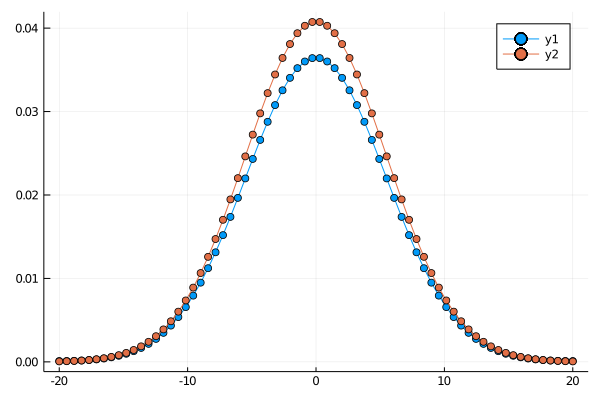

In [316]:
problem = ODEProblem((u,p,t) -> D²*u, u₀, (0.0,t))
method = CVODE_BDF(linear_solver=:Band,jac_upper=1,jac_lower=1)
solution = solve(problem,method)
plot(x,[solution(t),ϕ(x,t,10)],mark=:dot)

**13.8. Allen–Cahn equation.** We'll solve the Allen–Cahn equation using  Strang splitting. 

In [ ]:
L = 16; nₓ = 400; Δx = L/nₓ
T = 4; nₜ = 1600; Δt = T/nₜ
x = LinRange(-L/2,L/2,nₓ)'
u = @. tanh(x^4 - 16*(2*x^2-x'^2)) 
D = Tridiagonal(ones(nₓ-1),-2ones(nₓ),ones(nₓ-1))/Δx^2
D[1,2] *= 2; D[end,end-1] *= 2
A = I + 0.5Δt*D
B = I - 0.5Δt*D 
f = (u,Δt) -> @. u/sqrt(u^2 - (u^2-1)*exp(-50*Δt))
u = f(u,Δt/2)
anim = Animation()
for i = 1:nₜ
  (i%10)==1 && (plot(Gray.(u),border=:none); frame(anim))
  u = (B\(A*(B\(A*u))'))'
  (i<nₜ) && (u = f(u,Δt))
end
u = f(u,Δt/2); Gray.(u)
gif(anim, "allencahn.gif", fps = 30)

**14.7. Burgers' Equation.**

In [ ]:
U = (x,t) ->  @. (x/t)*(t<2)*(x>0)*(x<t) +    
  1*(t<2)*(x>t)*(x<1+t/2) + 
  (x/t)*(t≥2)*(x>0)*(x<sqrt(2t))

In [ ]:
nₓ = 80; x = LinRange(-1,3,nₓ); Δx = x[2]-x[1]; j = 1:nₓ-1
nₜ = 100; Lₜ = 4; Δt = Lₜ/nₜ
f = u-> u.^2/2; df = u -> u
u = (x.>=0).*(x.<=1) 
anim = @animate for i = 1:nₜ 
  α = 0.5*max.(abs.(df(u[j])),abs.(df(u[j.+1])))
  F = (f(u[j])+f(u[j.+1]))/2 - α.*(u[j.+1]-u[j])
  u -=  Δt/Δx*[0;diff(F);0]
  plot(x,u, fill = (0, 0.3, :blue))
  plot!(x,U(x,i*Δt), fill = (0, 0.3, :red))  
  plot!(legend=:none, ylim=[0,1])
end
gif(anim, "burgers.gif", fps = 15)

**14.8. Dam break problem.**

In [ ]:
δ = u -> diff(u,dims=1)
ϕ = t -> (abs(t)+t)./(1+abs(t))
fixnan(u) = isnan(u)||isinf(u) ? 0 : u
θ = δu -> fixnan.(δu[1:end-1,:]./δu[2:end,:])
∂ₓ(u) = (δu=δ(u);[[0 0];δu[2:end,:].*ϕ.(θ(δu));[0 0]])
F = u -> [u[:,1].*u[:,2] u[:,1].*u[:,2].^2+0.5u[:,1].^2]

In [ ]:
n = 100; x = LinRange(-.5,.5,n); Δx = x[2]-x[1]
T = 0.4; nₜ = ceil(T/(Δx/2)); Δt = (T/nₜ)/2; 
U = [0.8*(x.<0).+0.2 zero(x)] 
Uⱼ = view(U,1:n-1,:); Uⱼ₊₁ = view(U,2:n,:)
anim = @animate  for i = 1:nₜ
  U° = U-0.5*Δt/Δx*∂ₓ(F(U))
  Uⱼ₊₁ .= (Uⱼ+Uⱼ₊₁)/2 - δ(∂ₓ(U))/8 - Δt/Δx*δ(F(U°)) 
  U° = U-0.5*Δt/Δx*∂ₓ(F(U))
  Uⱼ .= (Uⱼ+Uⱼ₊₁)/2 - δ(∂ₓ(U))/8 - Δt/Δx*δ(F(U°))
  plot(x,U[:,1], fill = (0, 0.3, :blue))
  plot!(legend=:none, ylim=[0,1])
end
gif(anim, "dambreak.gif", fps = 15)

**15.2. Finite element method.**

In [ ]:
n=10; x=LinRange(0,1,n); h=x[2]-x[1]
α = fill(2/h-2h/3,n); α[[1,n]] /= 2; β = fill(-1/h-h/6,n-1)
A = SymTridiagonal(α,β)
b = [-2h^3/3; -4h^3/3 .- 8h*x[2:n-1].^2; -4h+8h^2/3-2h^3/3+1]
u = A\b
s = -16 .+ 8x.^2 .+ 15csc(1).*cos.(x)
plot(x,s,marker=:o,alpha=0.5); plot!(x,u,marker=:o,alpha=0.5)

**15.2. Finite element method.**

In [ ]:
n=8; x=LinRange(0,1,n+2); h=x[2]-x[1]
σ = (a,b,c) -> Tridiagonal(fill(a,n-1),fill(b,n),fill(c,n-1))/h^3
M = [σ(-12,24,-12) σ(-6,0,6);σ(6,0,-6) σ(2,8,2)];
b = [384h*ones(n);zeros(n)]
u = M\b
s = 16*(x.^4 - 2x.^3 + x.^2)
plot(x,[s [0;u[1:n];0]],marker=:o,alpha=0.5)
s = 16*(x.^4 - 2x.^3 + x.^2)
plot(x,[s [0;u[1:n];0]],marker=:o,alpha=0.5)

**16.1. Burgers' equation.** Fourier spectral methods perform poorly on problems that develop discontinuities such as Burgers' equation.  Gibbs oscillations develop around the discontinuity, and these oscillations will spread and grow because Burgers' equation is dispersive. Ultimately, the oscillations overwhelm the solution.

In [ ]:
using FFTW, DifferentialEquations
n = 128; x = (1:n)/n*(2π) .- π
ξ = im*[0:n/2; -n/2+1:-1]
f = (u,p,t) -> -real(ifft(ξ.*fft(0.5u.^2)))
u = solve(ODEProblem(f,exp.(-x.^2),(0.0,2.0)),DP5());

In [ ]:
@gif for t=0:.02:2
    plot(x,u(t),ylim=(-0.2,1.2))
end

**16.2. KdV equation.** We'll solve the KdV equation using integrating factors. We first set the initial conditions and parameters. Then, we define the integrating factor `G` and the right hand side `f` of the differential equation. Finally, we animate the solution. Notice the two soliton solution.

In [ ]:
using FFTW, Plots
ϕ = (x,x₀,c) -> 0.5c*sech(sqrt(c)/2*(x-x₀))^2
L = 30; T = 2.0; n = 256
x = (1:n)/n*L .- L/2
u₀ = ϕ.(x,-4,4) + ϕ.(x,-9,9)
iξ = im*[0:(n/2);(-n/2+1):-1]*2π/L;

In [ ]:
G = t -> exp.(-iξ.^3*t)
f = (w,p,t) -> -G(t).\(3iξ.*(fft(ifft(G(t).*w).^2)))

In [ ]:
w = solve(ODEProblem(f,fft(u₀),(0,T)),DP5())
u = t -> real(ifft(w(t).*G(t)))

In [ ]:
@gif for t=0:.01:2
  plot(x,u(t),ylim=(0,5))
end

**16.3. Swift–Hohenberg equation.** We'll use Strang splitting to solve the  Swift–Hohenberg equation.

In [ ]:
using FFTW, LinearAlgebra, Images
ϵ = 1; n = 256; ℓ = 100; N = 2000; Δt=100/N;
U = (rand(n,n).>.5) .- 0.5
ξ = [0:(n/2);(-n/2+1):-1]*2π/ℓ
D²= -ξ.^2 .- (ξ.^2)'
E = exp.(-(D².+1).^2*Δt)
f = U -> U./sqrt.(U.^2/ϵ + exp(-Δt*ϵ)*(1 .- U.^2/ϵ))
for i=1:600
   U = f(ifft(E.*fft(f(U))))
end
Gray.(clamp01.((real(U).+1)/2))